In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *
import copy

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
####################################### Set Axes
def set_axes(ax_list, xlim, ylim):
    for ax in ax_list:
        
        ax.set_ylim(ylim)
        ax.set_xlim(xlim) 
        ax.tick_params(which='major', length=8, width=1.5, direction='in')
        ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')  

        y_ax = ax.twinx()
        y_ax.set_ylim(ylim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=8, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')        

        x_ax = ax.twiny()
        x_ax.set_xlim(xlim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=8, width=1.0, direction='in')
        x_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(18) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(18) 
####################################### Plotting Function

In [3]:
calib_maglim = [3974, 6699, 9962, 11139, 12460, 13163, 19871, 
                21102, 22277, 26761, 28378, 29128, 38148, 41020, 
                41093, 44982, 45084, 46127, 49448, 50073, 53641, 67908, 72228]

W1_maglim = [38803, 39181, 39431, 39619, 40005, 40107, 40147, 40588, 
             40604, 41567, 41829, 42768, 5807403, 5057729, 4002181, 4321374, 37814, 
             14548, 14590]

table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)



In [4]:
mag_g = table['g_sss']
mag_r = table['r_sss']
mag_i = table['i_sss']
mag_z = table['z_sss']
mag_w1 = table['w1_sss']
mag_w2 = table['w2_sss']
logWimx   = table['logWimx']
P0_w2 = table['P0_w2']
pgc_id =  table['pgc']
pgc_tab = table['pgc']
u_tab   = table['u_sss']
g_tab   = table['g_sss']
r_tab   = table['r_sss']
i_tab   = table['i_sss']
z_tab   = table['z_sss']
w1_tab  = table['w1_sss']
w2_tab  = table['w2_sss']
m21_tab = table['m21']
inc_tab = table['P0_w2']

catal   = np.genfromtxt('ESN_HI_catal_all.csv' , delimiter=',', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc_catal   = catal['pgc']
R50u_catal  = catal['R50_u']
R50g_catal  = catal['R50_g']
R50r_catal  = catal['R50_r']
R50i_catal  = catal['R50_i']
R50z_catal  = catal['R50_z']
R50w1_catal = catal['R50_w1']
R50w2_catal = catal['R50_w2']
Sba_catal   = catal['Sba']
Wba_catal   = catal['Wba']


pgc = pgc_id
N = len(pgc)
inc  = np.zeros(N)
m21  = np.zeros(N)
Sba  = np.zeros(N)
Wba  = np.zeros(N)

uuu  = np.zeros(N)
ggg  = np.zeros(N)
rrr  = np.zeros(N)
iii  = np.zeros(N)
zzz  = np.zeros(N)
w11  = np.zeros(N)
w22  = np.zeros(N)

R50u  = np.zeros(N)
R50g  = np.zeros(N)
R50r  = np.zeros(N)
R50i  = np.zeros(N)
R50z  = np.zeros(N)
R50w1 = np.zeros(N)
R50w2 = np.zeros(N)

for i, idd in enumerate(pgc):
    if idd in pgc_catal:
        indx,   = np.where(pgc_catal==idd)
        R50u[i]  = R50u_catal[indx][0]
        R50g[i]  = R50g_catal[indx][0]
        R50r[i]  = R50r_catal[indx][0]
        R50i[i]  = R50i_catal[indx][0]
        R50z[i]  = R50z_catal[indx][0]
        R50w1[i] = R50w1_catal[indx][0]
        R50w2[i] = R50w2_catal[indx][0]
        Sba[i]   = Sba_catal[indx][0]
        Wba[i]   = Wba_catal[indx][0]
    if idd in pgc_tab:
        indx,  = np.where(pgc_tab==idd)    
        inc[i] = inc_tab[indx][0]
        uuu[i] = u_tab[indx][0]
        ggg[i] = g_tab[indx][0]
        rrr[i] = r_tab[indx][0]
        iii[i] = i_tab[indx][0]
        zzz[i] = z_tab[indx][0]
        w11[i] = w1_tab[indx][0]
        w22[i] = w2_tab[indx][0]
        m21[i] = m21_tab[indx][0]
    
mu50_u  = uuu+2.5*np.log10(2.*np.pi*(R50u*60)**2)-2.5*np.log10(Sba)
mu50_g  = ggg+2.5*np.log10(2.*np.pi*(R50g*60)**2)-2.5*np.log10(Sba)
mu50_r  = rrr+2.5*np.log10(2.*np.pi*(R50r*60)**2)-2.5*np.log10(Sba)
mu50_i  = iii+2.5*np.log10(2.*np.pi*(R50i*60)**2)-2.5*np.log10(Sba)
mu50_z  = zzz+2.5*np.log10(2.*np.pi*(R50z*60)**2)-2.5*np.log10(Sba)
mu50_w1 = w11+2.5*np.log10(2.*np.pi*(R50w1*60)**2)-2.5*np.log10(Wba)
mu50_w2 = w22+2.5*np.log10(2.*np.pi*(R50w2*60)**2)-2.5*np.log10(Wba)



X = (m21-w11) - (3.284*(logWimx-2.5)+2.230)

magCorrection = -1*(-0.15*(X)-0.12)

# magCorrection = -1*(-0.105*(pc0)-0.174)
# magCorrection += -1*(-0.031*(pc0)-0.125)
# magCorrection += -1*(-0.067*(pc0)-0.171)


# for j, m in enumerate(magCorrection):
#     if mag_g[j]<5 or mag_g[j]>20 or mag_z[j]<5 or mag_z[j]>20:
#         magCorrection[j] = 0
#         W1_maglim.append(pgc_id[j])

        

# magCorrection *= 0.



/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invali

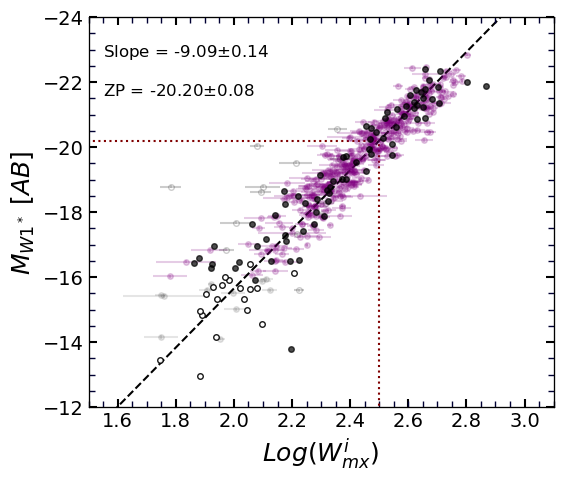

In [5]:
band = 'w1'

fig, ax, Clusters, S_ZP, zp_calibs = makeTF(table, pgcFaint=W1_maglim, calib_maglim=calib_maglim, 
                                 band=band, makePlot=True, 
                                            magCorrection=magCorrection, 
                                            addSouth=False,
                                            getZPcalib=True)

# ax.set_xlim(0,7)

0.6089579205840749 0.5442204122367129 60
60 -0.5442204122367138 -0.6038619488133962


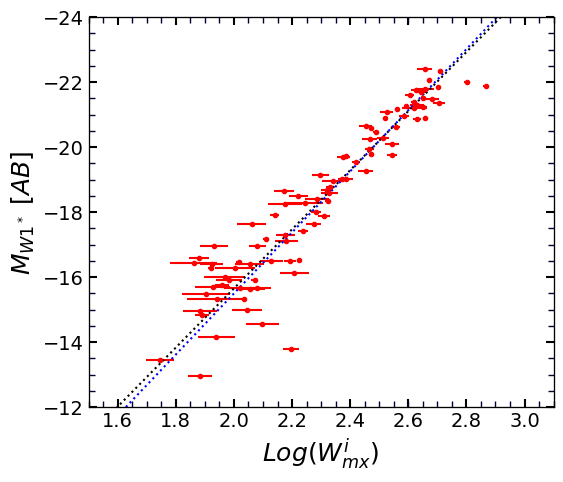

In [6]:
fig, ax = makeFig(band=band, xLim = (1.5,3.1), yLim = (-12,-24), MAGabs=True)


ax.errorbar(zp_calibs['logWimx'], zp_calibs['MAG'], xerr=zp_calibs['logWimx_e'], fmt='.', color='r')

slope = S_ZP[0]
slope_e = S_ZP[1]
zp    = S_ZP[2]
zp_e    = S_ZP[3]

x = np.linspace(0,5,20)
ax.plot(x, slope*(x-2.5)+zp, 'k:')

W = zp_calibs['logWimx']
We = zp_calibs['logWimx_e']
M = zp_calibs['MAG']

fit, cov = curve_fit(linfit, M, W-2.5, sigma=np.sqrt(We**2+0.01**2))
m, b = fit 
m0 = 1./m
b0 = -b/m
ax.plot(x, m0*(x-2.5)+b0, 'b:')

D = M - (m0*(W-2.5)+b0)
D = D[np.where(M<-17)]
We_ = We[np.where(M<-17)]
N = len(D)
sc = np.sqrt(np.sum(D**2)/(N-1))
sc_ = np.sqrt(np.sum(D**2/We_**2)/np.sum(1./We_**2))
print sc, sc_, N


D = W - ((M-b0)/m0+2.5)
D = D[np.where(M<-17)]
We_ = We[np.where(M<-17)]
N = len(D)
sc0 = np.sqrt(np.sum(D**2/We_**2)/np.sum(1./We_**2))
sc1 = np.sqrt(np.sum(D**2)/np.sum(We_**2/We_**2))
print N, sc0*m0, sc1*m0


0.26928079330041416 20 -0.2692807933004146
0.3835124402568569 19 -0.39322677933799843
0.42493305038956913 9 -0.41862591312565656
0.3101985999050745 0 0.0
0.4244783763280356 20 -0.4244783763280353


(-12, -26)

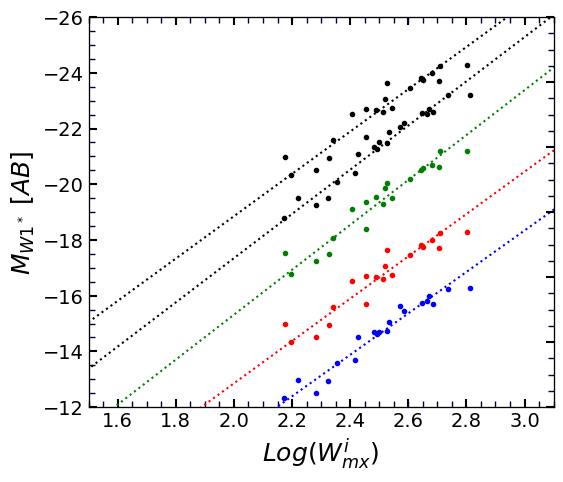

In [7]:
def pM(ax, W, M, color='k'):
    ax.plot(W, M, '.', color=color)
    fit, cov = curve_fit(linfit, M, W-2.5)
    m, b = fit 
    m0 = 1./m
    b0 = -b/m
    x = np.linspace(0,5,20)
    ax.plot(x, m0*(x-2.5)+b0, ':', color=color)
    D = M - (m0*(W-2.5)+b0)
    N = len(D)
    sc0 = np.sqrt(np.sum(D**2)/(N-1))
#     print np.sqrt(np.sum(D**2)/(N-1))
    D = W - ((M-b0)/m0+2.5)
    D = D[np.where(M<-17)]
    N = len(D)
    sc = np.sqrt(np.sum(D**2)/(N-1))
    print sc0, N, sc*m0
    
    
    


Ical   = np.genfromtxt('Ical.csv' , delimiter=',', 
                        filling_values=-1, names=True, dtype=None, encoding=None)


fig, ax = makeFig(band=band, xLim = (1.5,3.1), yLim = (-12,-24), MAGabs=True)
# ax.plot(Ical['logWimx'], Ical['MI'], 'r.')


x = np.linspace(0,5,20)
# ax.plot(x, slope*(x-2.5)+zp, 'k:')

DM = Ical['DM']
pgc = Ical['pgc']
Imag = Ical['I']
IlogWimx = Ical['logWimx']
IWmx = Ical['Wmx']
Iinc = Ical['inc']

ctl   = np.genfromtxt('zp_photom_reduced.csv' , delimiter='|', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
dist = ctl['d']


table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc_catal   = table['pgc']
i_tab   = table['i_']
Sqlt = table['Sqlt']
logWimx = table['logWimx']
Wmx = table['Wmx']
inc = table['inc']

i_lst = []
indx_lst = []

for i, idd in enumerate(pgc):
    if idd in pgc_catal:
        indx, = np.where(pgc_catal==idd)
        if Sqlt[indx][0]>2:
            i_lst.append(i)
            indx_lst.append(indx[0])
            
i_lst = np.asarray(i_lst)
indx_lst = np.asarray(indx_lst) 
            
pM(ax, IlogWimx[i_lst], Imag[i_lst]-DM[i_lst], color='k')
pM(ax, logWimx[indx_lst], Imag[i_lst]-DM[i_lst]+2, color='g')
pM(ax, logWimx[indx_lst], i_tab[indx_lst]-DM[i_lst]+4, color='r')
pM(ax, IlogWimx[i_lst], i_tab[indx_lst]-DM[i_lst]+6, color='b')


# pM(ax, np.log10(Wmx[indx_lst]/np.sin(np.pi*Iinc[i_lst]/180.)), Imag[i_lst]-DM[i_lst]-2, color='k')
pM(ax, np.log10(Wmx[indx_lst]/np.sin(np.pi*inc[indx_lst]/180.)), i_tab[indx_lst]-DM[i_lst]-2, color='k')


ax.set_ylim(-12,-26)

In [8]:
slope = S_ZP[0]
slope_e = S_ZP[1]
zp    = S_ZP[2]
zp_e    = S_ZP[3]

# zp_calibs = all_ZP(table, band=band, slope=slope, pgcFaint=calib_maglim)

# fig, ax = makeFig(band=band, xLim = (1.5,3.1), yLim = (-12,-24), MAGabs=True)

key0 = 'NEST_100002'
myCluster = Clusters[key0]
zp_virgo  = myCluster['zp']

MAG       = myCluster['mag']-zp_virgo+zp
MAG_w     = myCluster['mag_w']-zp_virgo+zp
logWimx   = myCluster['logWimx']
logWimx_w = myCluster['logWimx_w']
logWimx_e = myCluster['logWimx_e']
pgc       = myCluster['pgc']
pgc_w     = myCluster['pgc_w']

for i, key in enumerate(Clusters):
    if key!=key0:
        myCluster = Clusters[key]
        zp_ = myCluster['zp']
        
        MAG       = np.concatenate((MAG, myCluster['mag']-zp_+zp))
        MAG_w     = np.concatenate((MAG_w, myCluster['mag_w']-zp_+zp))
        logWimx   = np.concatenate((logWimx, myCluster['logWimx']))
        logWimx_w = np.concatenate((logWimx_w, myCluster['logWimx_w']))
        logWimx_e = np.concatenate((logWimx_e, myCluster['logWimx_e']))
        pgc       =  np.concatenate((pgc, myCluster['pgc']))
        pgc_w     =  np.concatenate((pgc, myCluster['pgc_w']))


indx = []
indx_ = []    
for i, id in enumerate(pgc):
    if not id in W1_maglim:
        indx.append(i)
    else:
        indx_.append(i) # faint

        
MAG_faint       = []
logWimx_faint   = []
pgc_faint       = []

if len(indx_)>0:
    MAG_faint       = MAG[indx_]
    logWimx_faint   = logWimx[indx_]
    pgc_faint       = pgc[indx_]

if len(indx)>0:
    MAG       = MAG[indx]
    logWimx   = logWimx[indx]
    logWimx_e = logWimx_e[indx]
    pgc       = pgc[indx]


In [9]:
catal   = np.genfromtxt('ESN_HI_catal_all.csv' , delimiter=',', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc_catal   = catal['pgc']
R50u_catal  = catal['R50_u']
R50g_catal  = catal['R50_g']
R50r_catal  = catal['R50_r']
R50i_catal  = catal['R50_i']
R50z_catal  = catal['R50_z']
R50w1_catal = catal['R50_w1']
R50w2_catal = catal['R50_w2']
Sba_catal   = catal['Sba']
Wba_catal   = catal['Wba']

pgc_tab = table['pgc']
u_tab   = table['u_sss']
g_tab   = table['g_sss']
r_tab   = table['r_sss']
i_tab   = table['i_sss']
z_tab   = table['z_sss']
w1_tab  = table['w1_sss']
w2_tab  = table['w2_sss']
m21_tab = table['m21']
inc_tab = table['P0_w2']


N = len(pgc)
inc  = np.zeros(N)
m21  = np.zeros(N)
Sba  = np.zeros(N)
Wba  = np.zeros(N)

uuu  = np.zeros(N)
ggg  = np.zeros(N)
rrr  = np.zeros(N)
iii  = np.zeros(N)
zzz  = np.zeros(N)
w11  = np.zeros(N)
w22  = np.zeros(N)

R50u  = np.zeros(N)
R50g  = np.zeros(N)
R50r  = np.zeros(N)
R50i  = np.zeros(N)
R50z  = np.zeros(N)
R50w1 = np.zeros(N)
R50w2 = np.zeros(N)

for i, idd in enumerate(pgc):
    if idd in pgc_catal:
        indx,   = np.where(pgc_catal==idd)
        R50u[i]  = R50u_catal[indx][0]
        R50g[i]  = R50g_catal[indx][0]
        R50r[i]  = R50r_catal[indx][0]
        R50i[i]  = R50i_catal[indx][0]
        R50z[i]  = R50z_catal[indx][0]
        R50w1[i] = R50w1_catal[indx][0]
        R50w2[i] = R50w2_catal[indx][0]
        Sba[i]   = Sba_catal[indx][0]
        Wba[i]   = Wba_catal[indx][0]
    if idd in pgc_tab:
        indx,  = np.where(pgc_tab==idd)    
        inc[i] = inc_tab[indx][0]
        uuu[i] = u_tab[indx][0]
        ggg[i] = g_tab[indx][0]
        rrr[i] = r_tab[indx][0]
        iii[i] = i_tab[indx][0]
        zzz[i] = z_tab[indx][0]
        w11[i] = w1_tab[indx][0]
        w22[i] = w2_tab[indx][0]
        m21[i] = m21_tab[indx][0]
    
mu50_u  = uuu+2.5*np.log10(2.*np.pi*(R50u*60)**2)-2.5*np.log10(Sba)
mu50_g  = ggg+2.5*np.log10(2.*np.pi*(R50g*60)**2)-2.5*np.log10(Sba)
mu50_r  = rrr+2.5*np.log10(2.*np.pi*(R50r*60)**2)-2.5*np.log10(Sba)
mu50_i  = iii+2.5*np.log10(2.*np.pi*(R50i*60)**2)-2.5*np.log10(Sba)
mu50_z  = zzz+2.5*np.log10(2.*np.pi*(R50z*60)**2)-2.5*np.log10(Sba)
mu50_w1 = w11+2.5*np.log10(2.*np.pi*(R50w1*60)**2)-2.5*np.log10(Wba)
mu50_w2 = w22+2.5*np.log10(2.*np.pi*(R50w2*60)**2)-2.5*np.log10(Wba)

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in log10


In [10]:
delta = MAG - (slope*(logWimx-2.5)+zp)
delta_e = np.sqrt(0.05**2+(slope_e*(logWimx-2.5))**2+(slope*logWimx_e)**2+zp_e**2)

delta_H = logWimx - ((MAG-zp)/slope+2.5)
f = (MAG-zp)/slope
delta_He = np.sqrt(logWimx_e**2+(f**2)*((0.05**2+zp_e**2)/(MAG-zp)**2+slope_e**2/slope**2))


g_i   = ggg-iii
i_w1  = iii-w11
r_w1  = rrr-w11
r_i   = rrr-iii
i_z   = iii-zzz
g_z   = ggg-zzz 
r_z   = rrr-zzz 
m21_g = m21-ggg
m21_r = m21-rrr 
m21_i = m21-iii
m21_z = m21-zzz 
m21_w = m21-w11

indx, = np.where(iii>5)
delta = delta[indx]
delta_H  = delta_H[indx]
delta_He  = delta_He[indx]
delta_e = delta_e[indx]
logWimx_ = logWimx[indx]
logWimxE_ = logWimx_e[indx]
MAG_ = MAG[indx]
iii   = iii[indx]
w11   = w11[indx]
g_i   = g_i[indx]
i_w1  = i_w1[indx]
r_w1  = r_w1[indx]
r_i   = r_i[indx]
g_z   = g_z[indx]
r_z   = r_z[indx]
i_z   = i_z[indx]
m21_g = m21_g[indx]
m21_r = m21_r[indx]
m21_i = m21_i[indx]
m21_z = m21_z[indx]
m21_w = m21_w[indx]
mu50_u  = mu50_u[indx]
mu50_g  = mu50_g[indx]
mu50_r  = mu50_r[indx]
mu50_i  = mu50_i[indx]
mu50_z  = mu50_z[indx]
mu50_w1 = mu50_w1[indx]
mu50_w2 = mu50_w2[indx]
inc = inc[indx]

indx, = np.where(w11>5)
delta = delta[indx]
delta_e = delta_e[indx]
delta_H  = delta_H[indx]
delta_He  = delta_He[indx]
logWimx_ = logWimx_[indx]
logWimxE_ = logWimxE_[indx]

MAG_ = MAG_[indx]
iii   = iii[indx]
w11   = w11[indx]
g_i   = g_i[indx]
r_w1  = r_w1[indx]
i_w1  = i_w1[indx]
r_i   = r_i[indx]
g_z   = g_z[indx]
r_z   = r_z[indx]
i_z   = i_z[indx]
m21_g = m21_g[indx]
m21_r = m21_r[indx]
m21_i = m21_i[indx]
m21_z = m21_z[indx]
m21_w = m21_w[indx]
mu50_u  = mu50_u[indx]
mu50_g  = mu50_g[indx]
mu50_r  = mu50_r[indx]
mu50_i  = mu50_i[indx]
mu50_z  = mu50_z[indx]
mu50_w1 = mu50_w1[indx]
mu50_w2 = mu50_w2[indx]
inc = inc[indx]


In [11]:
print len(delta_H), len(logWimxE_)
N = len(delta_H)
print slope*np.sqrt(np.sum(delta_H**2/logWimxE_**2)/np.sum(1./logWimxE_**2))
print slope*np.sqrt(np.sum(delta_H**2)/N)
print np.sqrt(np.sum(delta**2)/(N-1))

410 410
-0.45460141613228855
-0.5502725901085326
0.5509448842995242


-0.06158773292340136

-0.06158773292340136 0.5460236519325508
0.5459784864559246
0.5157147345275779
0.5184131810281967


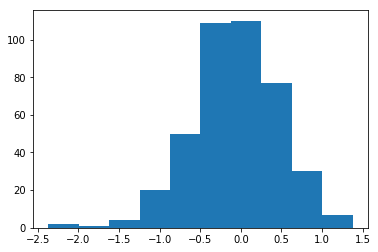

In [12]:
plt.hist(delta)
print np.median(delta)

Y_fit2 = delta
med = np.median(Y_fit2)
std = np.sqrt(np.mean((Y_fit2-med)**2))
indx, = np.where(Y_fit2<med+3*std)
Y_fit1 = Y_fit2[indx]
indx, = np.where(Y_fit1>med-3*std)
Y_fit2 = Y_fit1[indx]
print
print med, std
print np.std(delta)
print np.std(Y_fit2)
print np.sqrt(np.mean(Y_fit2**2))

In [13]:
def Plot_D_mu(ax, X, Y, xlim=None, ylim=[2.5,-3], x_text='', yerr=None,
              xlabel=False, ylabel=False, rangeLim=None):
    
    dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}
    
    indx = np.where(X>-10000)
    X = X[indx]
    Y = Y[indx]
    if not yerr is None: yerr=yerr[indx]
    
    if rangeLim is None:
        rangeLim = [-1000,1000]
        
    X_fit = []
    Y_fit = []
    if not yerr is None: Yerr=[]
    for i, yy in enumerate(Y):
        if yy<10.5 and yy>-10.5 and X[i]<rangeLim[1] and X[i]>rangeLim[0]:
            ax.plot(X[i], yy, '+', color='black')
            X_fit.append(X[i])
            Y_fit.append(yy)
            if not yerr is None: Yerr.append(yerr[i])
        else:
            ax.plot(X[i], yy, 'o', color='black', markerfacecolor='white')
    
    X_fit = np.asarray(X_fit)
    Y_fit = np.asarray(Y_fit)
    if not yerr is None: Yerr=np.asarray(Yerr)
    ####################################################
    if rangeLim[1] != 1000:
        ll = np.max([rangeLim[0],np.min(X_fit)])
        uu = np.min([rangeLim[1],np.max(X_fit)])
    else: 
        ll = np.min(X_fit)
        uu = np.max(X_fit)
    dd = (uu-ll)/5.
    
    for i in np.arange(ll,uu,dd):
        xp = []
        yp = []
        for ii in range(len(X_fit)):
            xi = X_fit[ii]
            if xi>=i and xi<i+dd:
                xp.append(xi)
                yp.append(Y_fit[ii])
        if len(xp)>0:
            ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                        color='red', alpha=1.0)     
    ####################################################
    
    if xlim is None:
        # ax.set_ylim([-2.5,2])
        Xlm = ax.get_xlim()
        set_axes([ax], Xlm, ylim)
    else:
        set_axes([ax], xlim, ylim)
    
    if yerr is None:
        fit, cov = curve_fit(linfit, X_fit, Y_fit)
    else:
        fit, cov = curve_fit(linfit, X_fit, Y_fit, sigma=Yerr)
    
    m, b = fit
    x = np.linspace(np.min(X),np.max(X), 100)
    y = m*x+b
    ax.plot(x, y, 'g-', linewidth=2)
    me = np.sqrt(cov[0,0])
    be = np.sqrt(cov[1,1])
    mbe = cov[1,0]

    dy = np.sqrt(x**2*me**2+be**2+2*x*mbe)
    ax.fill_between(x, y+2*dy, y-2*dy, color='r', alpha=0.3)

    Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()


    x0 = 0.97*Xlm[0]+0.03*Xlm[1]
    y0 = 0.07*Ylm[0]+0.93*Ylm[1]
    ax.text(x0,y0, "Slope = "+"%.2f" % m+'$\pm$'+"%.2f" % me, fontsize=16, color='k')
    y0 = 0.15*Ylm[0]+0.85*Ylm[1]
    ax.text(x0,y0, "ZP = "+"%.2f" % b+'$\pm$'+"%.2f" % be, fontsize=16, color='k')

    data = {'X':X_fit, 'Y':Y_fit}
    d = pd.DataFrame.from_dict(data)
    corr = d.corr()
    y0 = 0.23*Ylm[0]+0.77*Ylm[1]
    ax.text(x0,y0, r'$Corr.=$'+'%.2f'%corr['X']['Y'], fontsize=16, color='red')

    if xlabel:
        ax.set_xlabel(x_text, fontsize=20, labelpad=7)
    if ylabel:
        band_label = band
        if band=='w1' or band=='w2':
            band_label = band.upper()
        ax.set_ylabel(band_label+r'$^*-$'+' Mean Correalation', fontsize=20, labelpad=7)

    x0 = 0.65*Xlm[0]+0.35*Xlm[1]
    y0 = 0.95*Ylm[0]+0.05*Ylm[1]
    
    Y_fit2 = Y_fit
    X_fit2 = X_fit
    
    for i in range(5):
        med = np.median(Y_fit2)
        std = np.sqrt(np.mean((Y_fit2-med)**2))
        indx, = np.where(Y_fit2<med+3*std)
        Y_fit1 = Y_fit2[indx]
        X_fit1 = X_fit2[indx]
        indx, = np.where(Y_fit1>med-3*std)
        Y_fit2 = Y_fit1[indx]
        X_fit2 = X_fit1[indx]
    
    
    
    
    ax.text(x0,y0, "RMS = "+"%.2f" % np.sqrt(np.mean(Y_fit2**2))+' mag', fontsize=16, color=dye[band])
#     ax.text(x0,y0+0.2, "std = "+"%.2f" % np.std(Y_fit**2)+' mag', fontsize=16, color=dye[band])
    
    Delta_new = Y_fit2 - (m*X_fit2+b)
    
    x0 = 0.27*Xlm[0]+0.73*Xlm[1]
    ax.text(x0,y0, "-> "+"%.2f" % np.sqrt(np.mean(Delta_new**2)), fontsize=16, color='k') 
#     ax.text(x0,y0+0.2, "-> "+"%.2f" % np.std(Delta_new), fontsize=16, color='k') 
    
    return m, b

In [14]:
print len(inc), len(delta), len(MAG_)


410 410 410


(0.42191709096713814, -0.37580813604250296)


<ErrorbarContainer object of 3 artists>

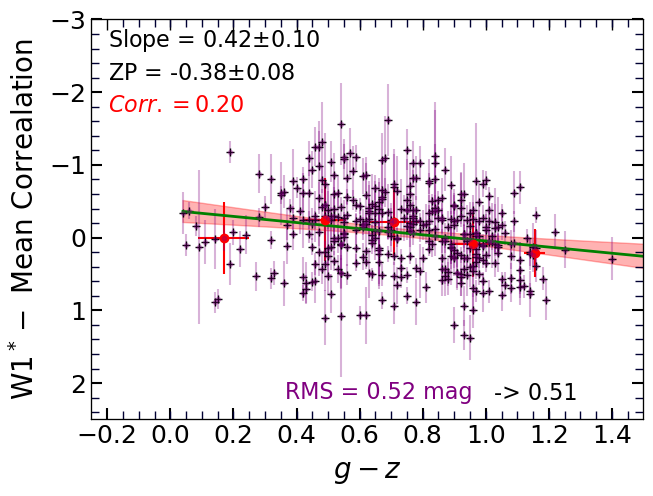

In [15]:
fig = py.figure(figsize=(12, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1]) 
ax1 = plt.subplot(gs[0])
ax1.set_xlim(-0.25,1.5)


indx, = np.where(MAG_<-17)


print Plot_D_mu(ax1, g_z[indx], delta[indx], yerr=None, 
          x_text=r'$g-z$', xlabel=True, ylabel=True, rangeLim=[-0.25,1.5])

ax1.errorbar(g_z[indx], delta[indx], yerr=delta_e[indx], fmt= '.', alpha=0.3, color='purple')

(-0.029729385615291815, -0.06611534194071589)


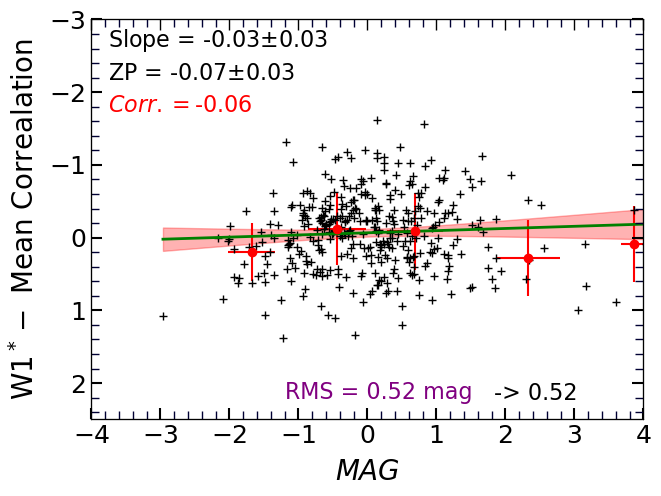

In [16]:
fig = py.figure(figsize=(12, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1]) 
ax1 = plt.subplot(gs[0])
ax1.set_xlim(-4,4)


indx, = np.where(MAG_<-17)


X = m21_w[indx] - (3.28*(logWimx[indx]-2.5)+2.23)


print Plot_D_mu(ax1, X, delta[indx], yerr=None, 
          x_text=r'$MAG$', xlabel=True, ylabel=True)




# ax1.errorbar(MAG_[indx], delta[indx], yerr=delta_e[indx], fmt= '.', alpha=0.3, color='purple')

(0.04639462576863518, -0.041324416502159345)


(0.5, -0.5)

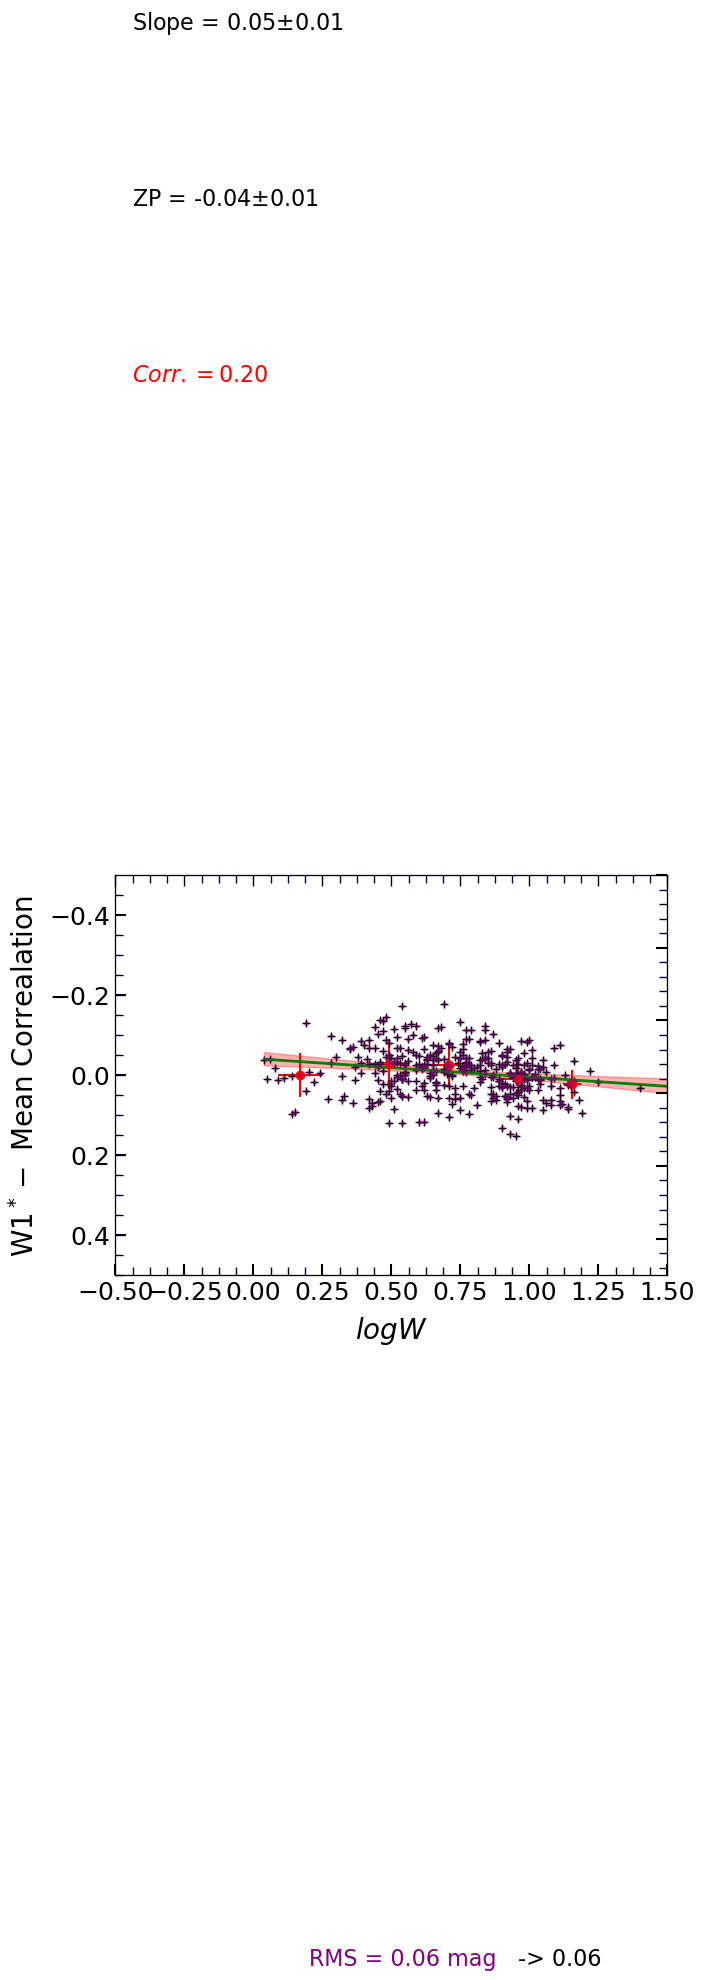

In [17]:
fig = py.figure(figsize=(12, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1]) 
ax1 = plt.subplot(gs[0])
ax1.set_xlim(-0.5,1.5)


indx, = np.where(MAG_<-17)


print Plot_D_mu(ax1, g_z[indx], delta_H[indx], yerr=None, 
          x_text=r'$logW$', xlabel=True, ylabel=True, rangeLim=[-0.5,1.5])

ax1.errorbar(g_z[indx], delta_H[indx], fmt= '.', alpha=0.3, color='purple')


ax1.set_ylim(0.5,-0.5)



In [18]:
def scatter(D, W, low, high):
    

    N = len(D)
    z1 = np.zeros(N)
    z2 = np.zeros(N)
    z1[np.where(W<=high)]=1
    z2[np.where(W>low)]+=1

    D_ = D[np.where(z1+z2==2)]    
    
    M = len(D_)
    sc = np.sqrt(np.sum(D_**2)/(M-1))
    print N, M, low, high, sc
    
    return sc



D = delta
W = logWimx_

scatter(D, W, 2., 2.2)
scatter(D, W, 2.2, 2.4)
scatter(D, W, 2.4, 2.6)
scatter(D, W, 2.6, 2.8)

410 26 2.0 2.2 0.7569164843773092
410 137 2.2 2.4 0.5729769266638803
410 162 2.4 2.6 0.4181765163300822
410 81 2.6 2.8 0.5272955171187576


0.5272955171187576

0.508160137218978
0.5075323912879005


(array([  2.,   1.,   4.,  20.,  50., 109., 110.,  77.,  30.,   7.]),
 array([-2.37052444, -1.99575103, -1.62097762, -1.24620421, -0.8714308 ,
        -0.49665739, -0.12188398,  0.25288943,  0.62766284,  1.00243625,
         1.37720966]),
 <a list of 10 Patch objects>)

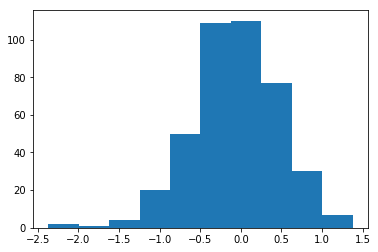

In [19]:
Y_fit2 = delta
std = np.sqrt(np.mean((Y_fit2)**2))
indx, = np.where(Y_fit2<3*std)
Y_fit1 = Y_fit2[indx]
indx, = np.where(Y_fit1>-3*std)
Y_fit2 = Y_fit1[indx]

std = np.sqrt(np.mean((Y_fit2)**2))
indx, = np.where(Y_fit2<3*std)
Y_fit1 = Y_fit2[indx]
indx, = np.where(Y_fit1>-3*std)
Y_fit2 = Y_fit1[indx]

std = np.sqrt(np.mean((Y_fit2)**2))
indx, = np.where(Y_fit2<3*std)
Y_fit1 = Y_fit2[indx]
indx, = np.where(Y_fit1>-3*std)
Y_fit2 = Y_fit1[indx]

std = np.sqrt(np.mean((Y_fit2)**2))
indx, = np.where(Y_fit2<3*std)
Y_fit1 = Y_fit2[indx]
indx, = np.where(Y_fit1>-3*std)
Y_fit2 = Y_fit1[indx]


N = len(Y_fit2)
print np.sqrt(np.sum(Y_fit2**2)/(N-1))

print std

plt.hist(delta)


